#### Tuning XGB Adjuster: Compas Data

In [1]:
from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_compas,
)

from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

2025-01-18 18:54:13.768991: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 18:54:13.771183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-18 18:54:13.801303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 18:54:13.801329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 18:54:13.801346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

#### Load dataset and set options

In [2]:
privileged_groups = [{"sex": 1}]
unprivileged_groups = [{"sex": 0}]
dataset_orig = load_preproc_data_compas(["sex", "race"])
dataset_orig_train, dataset_orig_test = dataset_orig.split(
    [0.9], shuffle=True, seed=1234
)

### Learn plan classifier without debiasing

In [3]:
from numpy import nan

In [5]:
base_settings = {
    "time_budget": 6000,  # total running time in seconds
    "metric": "log_loss",
    "estimator_list": [
        "xgboost",
    ],
}

In [6]:
plain_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=False,
    tune_hyperparameters_base=True,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
)

In [7]:
plain_model.fit(
    dataset=dataset_orig_train,
    test_dataset=dataset_orig_test,
    **xgb_kwargs,
)

### Apply in-processing algorithm based on adversarial learning

In [8]:
debiased_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    # debias=True,
    # adversary_loss_weight=1.0,
    # tune_hyperparameters_base=True,
    debias=False,
    tune_hyperparameters_base=False,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
    debug=False,
    task="classification",
)

In [9]:
xgb_kwargs["learning_rate"] /= 5
xgb_kwargs["n_estimators"] *= 5

In [10]:
debiased_model.fit(
    dataset=dataset_orig_train,
    test_dataset=dataset_orig_test,
)

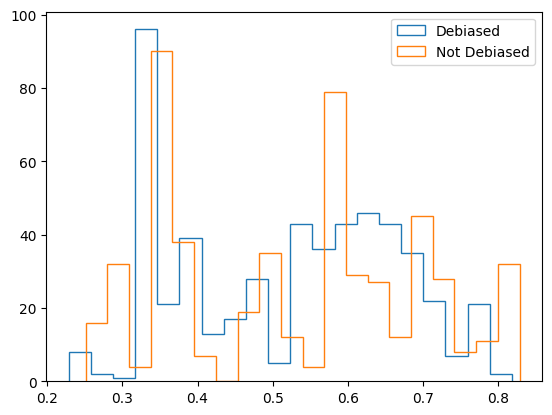

In [11]:
import matplotlib.pyplot as plt

bins = 20
probs_ad = debiased_model.predict_proba(dataset_orig_test)
base_probs = plain_model.predict_proba(dataset_orig_test)
# plt.hist(adjusted_probs, bins=bins, histtype="step", label="Fairness Adjuster")
plt.hist(probs_ad, bins=bins, histtype="step", label="Debiased")
plt.hist(base_probs, bins=bins, histtype="step", label="Not Debiased")
plt.legend()
plt.show()

In [12]:
if hasattr(plain_model.base_estimator, "best_config"):
    display(plain_model.base_estimator.best_config)
    display(plain_model.base_estimator.model.estimator.get_params(deep=True))

{'n_estimators': 5,
 'max_leaves': 7,
 'min_child_weight': 0.20011886112100682,
 'learning_rate': 0.8372314410308169,
 'subsample': 0.4268854156506455,
 'colsample_bylevel': 0.12935793135435744,
 'colsample_bytree': 0.9614957283426705,
 'reg_alpha': 0.12852173870742548,
 'reg_lambda': 0.0009765625}

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': [],
 'colsample_bylevel': 0.12935793135435744,
 'colsample_bynode': None,
 'colsample_bytree': 0.9614957283426705,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.8372314410308169,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 0,
 'max_leaves': 7,
 'min_child_weight': 0.20011886112100682,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 5,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.12852173870742548,
 'reg_lambda': 0.0009765625,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.4268854156506455,
 'tree_method': 'hist',
 'validate_parameters

In [13]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(
    dataset_nodebiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.270381
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.282804


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.655303
Test set: Balanced classification accuracy = 0.653755
Test set: Disparate impact = 0.632014
Test set: Equal opportunity difference = -0.219511
Test set: Average odds difference = -0.228074
Test set: Theil_index = 0.226547


In [14]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)
print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(
    dataset_debiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_train.mean_difference()
)

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_test.mean_difference()
)


display(Markdown("#### Plain model - without debiasing - classification metrics"))
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())


display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_debiasing_test.accuracy()
)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_debiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_debiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_debiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.270381
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.282804


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.240000
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.233069


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.655303
Test set: Balanced classification accuracy = 0.653755
Test set: Disparate impact = 0.632014
Test set: Equal opportunity difference = -0.219511
Test set: Average odds difference = -0.228074
Test set: Theil_index = 0.226547


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.643939
Test set: Balanced classification accuracy = 0.641107
Test set: Disparate impact = 0.693031
Test set: Equal opportunity difference = -0.157658
Test set: Average odds difference = -0.189022
Test set: Theil_index = 0.217608
